Initial Analysis of Ames Housing Data

In [18]:
#import modules
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from patsy import dmatrix
import seaborn as sns

I am defining a function to load the data. It reformats the data a little by: 
    -Renaming features that start with a number so that patsy can be used to create decision matrices
    -Replacing missing values with NaN or an expected value for the feature
    

Here is a list of the features that some subjects lack. Total number of subjects is 1460.
MasVnrType 1452
MasVnrArea 1452
BsmtQual 1423
BsmtCond 1423
BsmtExposure 1422
BsmtFinType1 1423
BsmtFinType2 1422
Electrical 1459
FireplaceQu 770
GarageType 1379
GarageYrBlt 1379
GarageFinish 1379
GarageQual 1379
GarageCond 1379
PoolQC 7
Fence 281
MiscFeature 54
PoolArea 8 #This is number of non-zero samples
MiscVal 21 #num of samples

I see that PoolQC, Fence, and MiscFeature, Pool Area, MiscVal are contained by relatively few training subjects, so I will exclude these features for simplicity.

In [8]:
#load data. Loads and reformats the training data


def load_data():
    df = pd.read_csv('/Users/martinrozycki/Documents/DataScience/Kaggle/Ames/train.csv',index_col=0)
    print df.shape

    #Make substitutions so that patsy dmatrix doesn't break
    df['FirstFlrSF'] = df['1stFlrSF']
    df['SecondFlrSF'] = df['2ndFlrSF']
    df['ThreeSsnPorch'] = df['3SsnPorch']
    df = df.drop(['1stFlrSF','2ndFlrSF','3SsnPorch'],axis=1)
    
    #Drop rare features
    df = df.drop(['PoolQC','Fence','MiscFeature','PoolArea','MiscVal'],axis=1) #Very few subjects have these features
    
    #There are only 8 subjects who lack MasVnrArea. Since it looks like an important feature based on the regressions below, it will
    #Be dropped as well, since we are not really losing any power by dropping only 8 of 1460 subjects.
    nullSubs = df[ pd.isnull( df['MasVnrArea']) ].index
    df = df.drop(nullSubs,axis=0)

    #A lot of the categorical features are labeled NaN for subjects that lack this particalur feature.
    #It would be better to label them as their own group, eg. subjects with "NA" in the GarageType feature
    #have that relabeled as "No Garage Type.", and together become a subgroup of the data.

    #Repalce missing values with feature expected values
    features = df.columns.drop('SalePrice')
    N = len(features) 
    featToLabel = []
    for f in features:
        S = sum(~pd.isnull(df[f]))
        if S < 1460:
            featNullSubs = df[ pd.isnull(df[f]) ].index
            if df.loc[featNullSubs,f].dtype == 'object':
                df.loc[featNullSubs,f] = 'NotAvailable'
            else:
                if f == 'GarageYrBlt':
                    df.loc[featNullSubs,f] = df.loc[featNullSubs,'YearBuilt'] #Subsitute year built values. Best estimate. See below.
                elif f == 'LotFrontage':
                    df.loc[featNullSubs,f] = 0 #is this the right decision? Could set them to average?
    print df.shape
    return df



Here we have a 2d histogram to show that garage year built and house hear built are correlated. 
We can see that the count of subjects off of the y=x line is very low, so we can approximate 
a missing garage year built with the year the house was built.

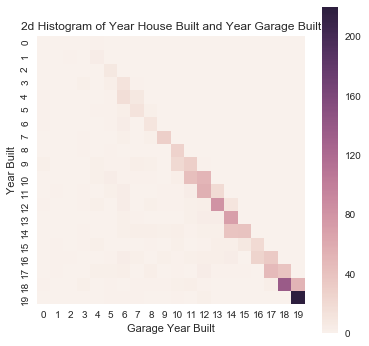

In [3]:
#Are garage year built and year built correlated? --They look like it in the linear regressions?
df = pd.read_csv('/Users/martinrozycki/Documents/DataScience/Kaggle/Ames/train.csv',index_col=0)
gSubs = df[ ~pd.isnull( df['GarageYrBlt']) ].index
H, xedges, yedges = np.histogram2d(df.loc[gSubs,'GarageYrBlt'].values,df.loc[gSubs,'YearBuilt'].values,bins=20)

fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(6, 6))
#ax.set_title('imshow: equidistant')
#im = plt.imshow(H)
import seaborn as sns
sns.heatmap(H,  square=True, );
ax.set_xlabel('Garage Year Built')
ax.set_ylabel('Year Built')
ax.set_title('2d Histogram of Year House Built and Year Garage Built')

Let's get an idea of what the data tells us by making univariate plots w/ linear regression.

(1460, 80)
(1452, 75)
33


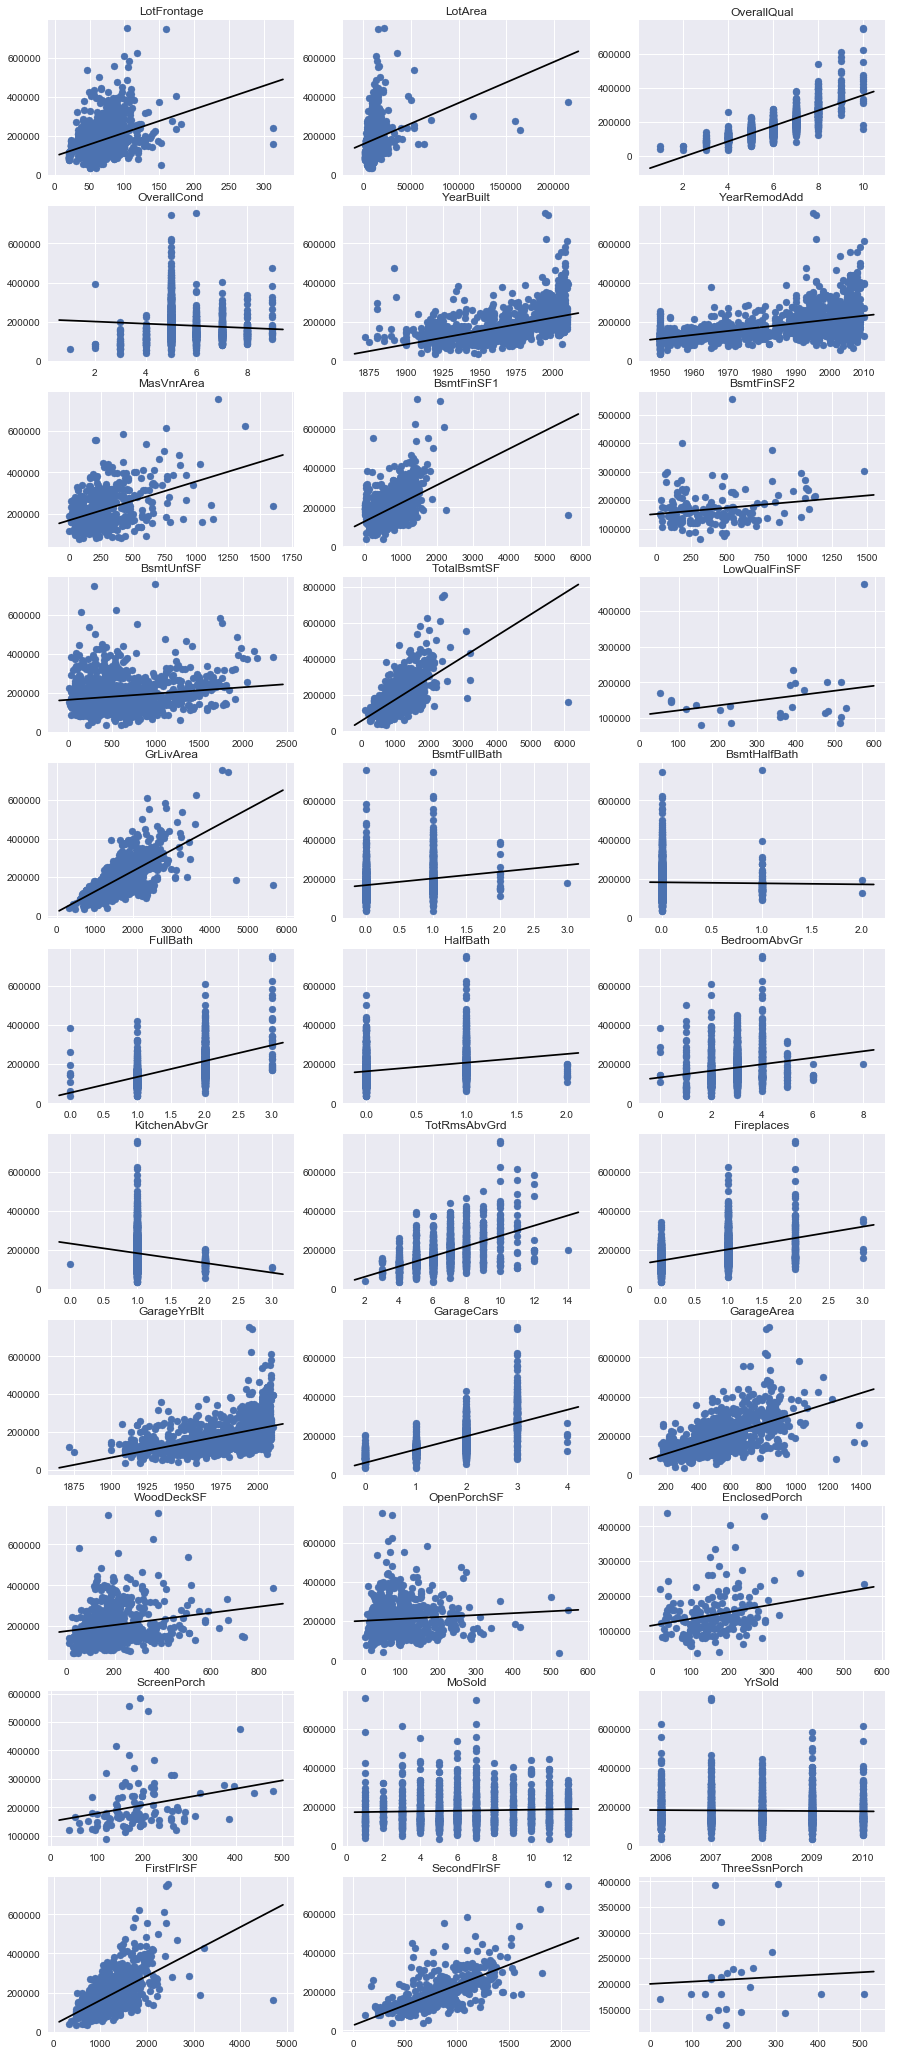

In [9]:
#Univariate Linear Regression on Data
df = load_data()

features = df.columns.drop('SalePrice')
N = len(features) 

#Let's ignore categorical, non-orignal feautres for linear regression
nonCatIndex = np.where(~(df[features].dtypes == 'object') )
nonCatFeat = features[nonCatIndex]
nonCatFeat = nonCatFeat.drop('MSSubClass') #Categorical. But of int64 dtype
Nnumerical = len(nonCatFeat)
print Nnumerical


#If a variable is continuous, let's drop it's zero values, since these are throwning off regressions.
#We see that greater than 30 features means that a feature is continuous
continList = []
for f in nonCatFeat:
    #print f,len(np.unique(df[f].values))
    if len(np.unique(df[f].values)) > 30:
        continList.append(f)
        
#Ooops. Actually here are 2 continuous features that missed the continuous sample cut
continList.append('ThreeSsnPorch')
continList.append('LowQualFinSF') 

import copy
regressDF = copy.deepcopy(df[nonCatFeat]) #We will run regressions within this dataframe. 
#But dropping zero's of continuous features
for f in continList:
    zeroIndex = regressDF[ regressDF[f] == 0  ].index
    regressDF.loc[zeroIndex, f ] = np.NaN
    


coefArray = np.zeros([Nnumerical,2]) #array to hold correlation coef
#Should also plot every single linear regression and look at them
fig, ax = plt.subplots(nrows=11,ncols=3,figsize=[15,37])
rCount = 0
cCount = 0
for f in nonCatFeat:
 
    nonNull = regressDF[ ~pd.isnull(regressDF[f]) ].index
    X = dmatrix(f,data=regressDF)
    Y = df.loc[nonNull,'SalePrice'].values

    L = sm.OLS(endog=Y,exog=X)
    results = L.fit()

    #Plot Scatter
    ax[rCount][cCount].scatter(X[:,1],Y)
    ax[rCount][cCount].set_title(f)
    #Plot Fit
    xlims = ax[rCount][cCount].get_xlim()
    ymin = [results.params[0] + results.params[1]*xlims[0]]
    ymax = [results.params[0] + results.params[1]*xlims[1]]
    
    ax[rCount][cCount].plot(xlims,[ymin,ymax],'k-')
    
    if not cCount == 2:
        cCount = cCount + 1
    else:
        rCount = rCount + 1
        cCount= 0


    
    
    
    



Regressions seems to reveal some important trends. We see that Square Footage/Area is important in general. For example ,take a loot at FirstFlrSF, SecondFlrSF, GrLivArea, LotFrontage, etc. Quality is also another very important feature (OverallQual). And number of full baths.

In general, The above analysis reveals trends that I, an ordinary person, would expect-- that bigger, nicer houses cost more.

The above analysis skipped out on analyzing categorical features. Let's do feature ranking with a random forest to see if any important features are found when we include those.

In [15]:
#Run a random forest for feature seleciton
from sklearn.ensemble import RandomForestRegressor

#I have taken care of replacing NaN features with non-null values
assert np.sum(pd.isnull(df.values)) == 0

CatFeat = features[ ~features.isin(nonCatFeat) ] #All features not in above regressions are categorical

#Need to to one hot encoding to analyze these categorical features
X = pd.get_dummies( df[features], columns = CatFeat )

#Run Random Forest Regression
rf = RandomForestRegressor()
rf.fit(X.values, df['SalePrice'].values)

#Sort features by importance and plot
importances = pd.Series(rf.feature_importances_,index=X.columns)
importancesHead = importances.sort_values(ascending=False).head(20)




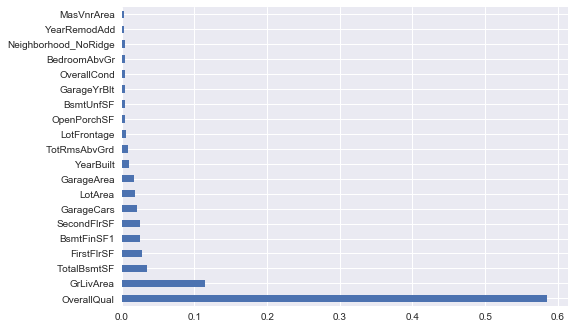

In [16]:
importancesHead.plot(kind='barh')

As expected, we see quality and property size features dominating. I am a bit surprised that overall quality dominates so much, however. 

It is interesting that neighborhood barely shows up. Perhaps the neighborhoods aren't that different in Ames, Iowa?

25


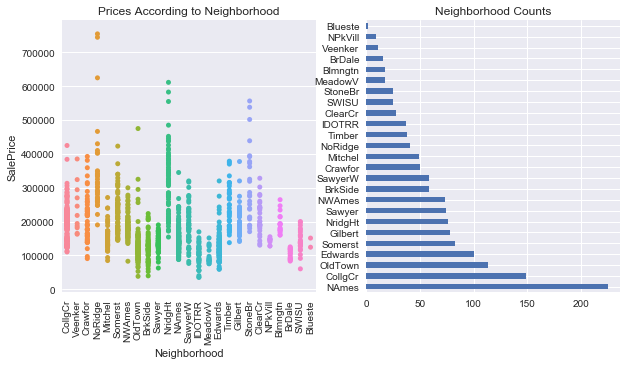

In [51]:
fig , ax = plt.subplots(nrows=1,ncols=2,figsize=[10,5])
sns.stripplot(x="Neighborhood", y="SalePrice", data=df, ax=ax[0])
ax[0].set_xticklabels(ax[0].xaxis.get_majorticklabels(), rotation=90)
ax[0].set_title('Prices According to Neighborhood')

print len(df['Neighborhood'].unique())
df['Neighborhood'].value_counts().plot(kind='barh',ax=ax[1])
ax[1].set_title('Neighborhood Counts')


So we see that there are different prices according to neighborhood, it just didin't come out as an important feature in our analysis.

Anyway, to sum this all up, we see that only a few features seem to dominate what determines housing prices. They make sense intuitively as well, as we would expect larger and higher quality homes to cost more. I suspect that if we predict price on the test set, we will do just fine using only these first few important features. I will do this in a subsequent script.